# Background
COVID-19 outbreak is such an unprecedented event in modern history in terms of its impact of our lives. From the shortage of toilet paper, introducing a new working environment, to the facing of global (even local) travel restrictions, the list goes on (for my previous articles about these topics, please visit to my LinkedIn page for more details; https://www.linkedin.com/pulse/3-ways-how-coronavirus-can-change-our-workplace-joonsoo-kevin-kim/, https://www.linkedin.com/pulse/statistics-between-coronavirus-toilet-paper-joonsoo-kevin-kim/). 

In this jupyter notebook, I wanted to investigate how did the spread of COVID-19 affected our daily commute in 2020. More specifically, this study will answer; in which time windows in 2020 we observed significant pattern of impact of COVID-19 infection to people’s tendency to commute, and how did this pattern change over time. This will lead us to think about some hypothesis of people’s commuting behavior in response to the spread of disease (or fear), which I’m not going to dive too deep because I believe it’s an area specialized for behavior economists or behavior psychologists - apologize the lack of my domain knowledge in this area!

# Updates

6/15/2021 Updates:

1) Since this is essentially looking rolling-based date data backward, we should capture the data from 'End_Date' perspective, not 'Start_Date' (Cell #7 & #8).

2) Case with rolling 10, 20, 30, 40 days was updated (Cell #11, #12 & #13). From the original post, the operator ran only with 20 rolling days senario.

# Preparation - Packages Installation
All packages needed to run this notebook are included as follows:

In [1]:
## Import Packages
# Data operation packages
import pandas as pd
import numpy as np
import itertools
from datetime import datetime
from datetime import timedelta

# Data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# Data Gathering & Loading
First, I picked Seattle downtown area to run this experiment for three main reasons; 1) Seattle is my personal favorite place on the earth😊, 2) Since Seattle is surrounded by waters, it is easier to gather the sample that closely represents the truth (A ~ D points in the map below), 3) Lastly, both King County, and State of Washington provide really good quality of data to the public.

Please refer to following links for the data source:

WSDOT Geo-Portal Link (https://www.wsdot.wa.gov/data/tools/geoportal/)

King County COVID Statistics (https://kingcounty.gov/depts/health/covid-19/data/daily-summary.aspx)

In [2]:
## Seattle traffic data source and its map
URL = 'https://github.com/snowjs0212/PythonSketchbook/blob/master/SourceFiles/SeattleTraffic.jpg?raw=true'
Image(url= URL, width=600, height=600)

In [3]:
## Data Loading
# Import source file
url = 'https://raw.githubusercontent.com/snowjs0212/PythonSketchbook/master/SourceFiles/factCOVID%2BGgle%2BTraffic.csv'
df = pd.read_csv(url, index_col = 0)

# Filter data only with weekdays records
df = df[df.WkendWkDay=='Weekday'].reset_index()
df.Date = pd.to_datetime(df.Date)
print(df.columns)

Index(['Date', 'DayOfWeek', 'WkendWkDay', 'All_Test_Results', 'Positives_N',
       'Positives_R', 'Hospitalizations', 'Deaths', 'Ggle_Corona',
       'EBoundPeak', 'WBoundPeak', 'TrafficPeakTotal',
       'All_Test_Results_NormZ', 'Positives_N_NormZ', 'Positives_R_NormZ',
       'Hospitalizations_NormZ', 'Deaths_NormZ', 'Ggle_Corona_NormZ',
       'EBoundPeak_NormZ', 'WBoundPeak_NormZ', 'TrafficPeakTotal_NormZ'],
      dtype='object')


# Exploration Part 1 - Correlation Matrix
The purpose of having a correlation matrix among all attributes is the find out which of COVID related attributes cause the most inverse effect on the traffic volume related attributes.

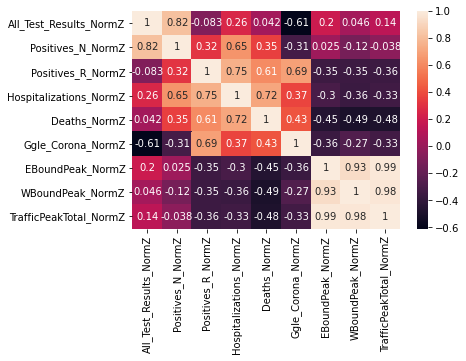

In [4]:
# Correlation Matrix
df_corr_mat = df[[
    'All_Test_Results_NormZ'
    ,'Positives_N_NormZ'
    ,'Positives_R_NormZ'
    ,'Hospitalizations_NormZ'
    ,'Deaths_NormZ'
    ,'Ggle_Corona_NormZ'
    ,'EBoundPeak_NormZ'
    ,'WBoundPeak_NormZ'
    ,'TrafficPeakTotal_NormZ']]

corr_mat = df_corr_mat.corr()

sns.heatmap(corr_mat, annot = True)
plt.show(sns)

# Exploration Part 2 - Line Plots
Since we now have two attributes ('Deaths_NormZ', 'TrafficPeakTotal_NormZ' that are most inversely correlated, we can visualize these two attributes in line chart together to confirm our hypothesis; COVID related death toll really did make people to travel less for commute based on the visual representation.

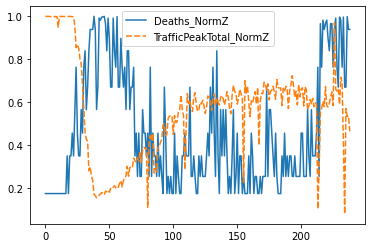

In [5]:
## Plots by seaborn package
df_line = df[['Date', 'Deaths_NormZ', 'TrafficPeakTotal_NormZ']]
sns.lineplot(data=df_line)
plt.show()

In [6]:
## Plots by Excel on monthly normalized average of two columns
URL = 'https://github.com/snowjs0212/PythonSketchbook/blob/master/SourceFiles/Plot.jpg?raw=true'
Image(url= URL, width=600, height=600)

#  Dynamic Time Lagged Cross Correlation (TLCC) Operator
Visual evidence of time-series line plots exists to prove there was a significantly negative correlation between the COVID-19 related death toll and traffic volume on the road. However, to convey more robust argument, I decided to run Pearson correlation computation through all possible time windows available in the year 2020. For more details on this operator, please read my previous article: https://www.linkedin.com/pulse/dynamic-time-lagged-cross-correlation-tlcc-operator-python-kim/.

In [7]:
"""
Created on Tue May 18 23:54:45 2021
@author: KevinJoonsoo
"""

import itertools
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

class dynamicTLCC():  
    """
    By Joonsoo Kim
    
    Summary:
        
        This operator allows users to run Time Lagged Cross Correlation across 
        all possible time intervals in a given data set. Also this allows users
        to modify the size of each time interval (n) and lag (L) to add 
        flexibility on the analysis of a pared time series data sets.
    
    Arguments:
        
        wd: working directory
        filename: file that contains time series data
        includeWknd: to include weekend for running model
        n: size of each time interval
        date_col: the name of column that contains 'date' field
        x1: first time series array (column) name
        x1: second time series array (column) name
        L: lag between 'X1' and 'X2'
    """
    def __init__(self, df):
        self.df = df
        
    def filterWeekend(self, includeWknd):
        if includeWknd == 'Y':
            self.df = self.df
        elif includeWknd == 'N':
            self.df = self.df[self.df.WkendWkDay=='Weekday'].reset_index()
        else:
            self.df = None
            print("Error: Select 'Y' or 'N' for 'includeWknd' argument.")

    def parseDate(self, n, date_col):
        self.n = n
        self.date_col = date_col
        df_date = self.df[date_col]
        
        iterators = list(itertools.tee(df_date, n))
        for pos, iterator in enumerate(iterators):
            next(itertools.islice(iterator, pos, pos), None) 
        date_zip_ = zip(*iterators)
        self.date_list = [i for i in date_zip_]

    def tlcc(self, x1, x2, L=0):
        date_list = self.date_list
        df = self.df
        date_col = self.date_col
        
        end_date = []
        correl = []
        for date in date_list:
            end_d = max(date).strftime('%d-%b-%Y')
            df_ = df[df[date_col].isin(date)].reset_index()
            end_date.append(end_d)
            correl.append(df_[x1].corr(df_[x2].shift(L)))
        self.output = dict(zip(end_date, correl))
        
        return(self.output)

# Parameters
date_col_ = 'Date'
x1_ = 'Deaths_NormZ'
x2_ = 'TrafficPeakTotal_NormZ'

# Rendering Operator (Case1: Rolling 20 Days)
To investigate a true commuting traffic volume, I rendered this operator against weekdays’ data set and excluding all weekends’ traffic data (includeWknd = ‘N’). Also limited the length of each time window to 20 days (n=20), hence 20 working days since all weekend days were excluded. I must confess that this argument of ’20 days’ came out arbitrarily, and with additional efforts this can be turned into optimization problem to find out what would be the most optimal length of days to capture the significance of correlation in the data sets most effectively.

In [8]:
# Rendering functions
run = dynamicTLCC(df)

# Only interested in weekday's commute, hence includeWknd = 'N'
run.filterWeekend(includeWknd='N')

# Computing an array of correlations for rolling 20 days
run.parseDate(n=20, date_col=date_col_)
result = run.tlcc(x1=x1_, x2=x2_)

# Exporting outcomes
df_export = pd.DataFrame(result, index=[0]).T.reset_index()
df_export.columns = ['End_Date', 'Correlation']
df_export = df_export.fillna(0)

# Result
The result indicates that toward the end of February to early March, normalized death counts by COVID and traffic volume in peak commute hour showed ‘very strong’ negative correlation within 20 working days of time window. In contrast, these two data sets showed ‘moderate’ positive correlation within some time blocks in July and November.

In [9]:
df_export.sort_values(by='Correlation')[0:7]

,End_Date,Correlation
20,27-Mar-2020,-0.866224
19,26-Mar-2020,-0.864740
18,25-Mar-2020,-0.848432
17,24-Mar-2020,-0.834374
16,23-Mar-2020,-0.809452
25,03-Apr-2020,-0.807505
26,06-Apr-2020,-0.797542


In [10]:
df_export.sort_values(by='Correlation', ascending=False)[0:7]

,End_Date,Correlation
118,12-Aug-2020,0.522127
213,23-Dec-2020,0.494993
119,13-Aug-2020,0.479511
214,24-Dec-2020,0.465320
212,22-Dec-2020,0.462946
122,18-Aug-2020,0.457846
121,17-Aug-2020,0.441805


# Rendering Operator (Case2: Rolling 10, 20, 30, 40 Days)
With the same operator, running the correlation output with rolling 10, 20, 30, 40 days cases (updated 6/15/2021).

In [11]:
# Rendering functions
run = dynamicTLCC(df)

# Only interested in weekday's commute, hence includeWknd = 'N'
run.filterWeekend(includeWknd='N')

# Computing an array of correlations for rolling 10, 20, 30, 40 days
n_list = [10, 20, 30, 40]
df_export = []

for i in n_list:
    run.parseDate(n=i, date_col=date_col_)
    output_ = run.tlcc(x1=x1_, x2=x2_)
    df_ = pd.DataFrame(output_, index=[0]).T.reset_index()
    df_.insert(0, column='N', value=i)
    df_ = df_.fillna(0)
    df_export.append(df_)
    
df_export = pd.concat(df_export)
df_export.columns = ['N', 'End_Date', 'Correlation']

In [12]:
df_export.sort_values(by='Correlation')[0:10]

,N,End_Date,Correlation
0,40,27-Mar-2020,-0.913476
8,40,08-Apr-2020,-0.900902
11,40,13-Apr-2020,-0.900128
10,30,27-Mar-2020,-0.899681
10,40,10-Apr-2020,-0.899633
7,40,07-Apr-2020,-0.899136
9,40,09-Apr-2020,-0.899082
6,40,06-Apr-2020,-0.896155
9,30,26-Mar-2020,-0.893043
5,40,03-Apr-2020,-0.892326


In [13]:
df_export.sort_values(by='Correlation', ascending=False)[0:10]

,N,End_Date,Correlation
214,10,10-Dec-2020,0.928688
38,10,08-Apr-2020,0.749675
40,10,10-Apr-2020,0.669152
213,10,09-Dec-2020,0.630118
39,10,09-Apr-2020,0.629415
119,10,30-Jul-2020,0.572349
138,10,26-Aug-2020,0.562544
132,10,18-Aug-2020,0.555389
131,10,17-Aug-2020,0.523931
118,20,12-Aug-2020,0.522127


# Conclusion
Seattle was one of the major U.S. metropolitan areas that experienced an early hit of COVID-19 infection started in February 2020. This empirical evidence shows that the hit of COVID-19 immediately affected general public’s commuting behavior. Whether it was due to a quick WFH transition imposed by major companies in Seattle area or spread of fear amongst public in the area that discouraged travels. As time passed, this correlation became weak and eventually switched the pattern in the opposite direction; maybe those who feared in the early stage of outbreak were more tolerated to be on the road.

The result seems to be more obvious if running the operator by rolling 10, 20, 30, 40 days (updated 6/15/2021).

I would defer the next stage of research to those who are specialized in these domain subjects which could range widely from behavior economics to public health. What I can do instead is to capture the signal out of raw data and show the patterns for the further analysis, and it is fun work to do!
Please feel free to reach out to me if you have any comments or questions.